

## **Discrete-Time Quantum Walk (DTQW)**

### **1. Introduction**

For this project, I implemented a **Quantum Walk**, which is the quantum mechanical analog of the classical random walk. To understand my approach, think of a classical walker flipping a coin and moving left or right based on the result. Over time, that classical walker’s position settles into a Gaussian distribution centered at the origin—a phenomenon known as diffusive spreading ($O(\sqrt{t})$).

In my quantum implementation, I replaced that random coin flip with a **superposition** and the movement with a unitary evolution. Because I am working with quantum mechanics, I deal with amplitudes rather than probabilities. This allows the various paths the walker takes to **interfere** with one another. Consequently, my simulation demonstrates **ballistic spreading** ($O(t)$)—a quadratic speedup that is the fundamental engine behind many quantum search algorithms.

### **2. The System Architecture**

I constructed the walk on a specific Hilbert space $H=H_c⊗H_p$
​, which consists of two distinct components:
<ul>
<li>  <b>The Coin Space ($H_c$):</b> I used a single qubit to represent the "direction" of the walker.
<ul>
<li> $∣0⟩$ : Represents "Right" </li>
<li> $∣1⟩$ : Represents "Left" </li>
</ul>
</li>
<li> <b>The Position Space ($H_p$):</b>  To map the walker's location, I utilized a register of qubits representing nodes on a graph. For a graph with  nodes, I allocated  qubits.</li>
</ul>

### **3. The Algorithm Execution**

I defined a single step of the walk using the unitary operator $U=S⋅(C⊗I)$, which I apply $t$ times. Here is how I structured each step:

**Step 1: The Coin Toss ($C$)**
I apply a **Hadamard Gate ($H$)** to the coin qubit. This is a crucial distinction from the classical approach; instead of the coin landing on heads *or* tails, the Hadamard puts the coin in a superposition of both: $$ |0⟩ \stackrel{H}{\longrightarrow}\frac{∣0⟩+∣1⟩}{\sqrt{2}}$$



This operation forces the walker in my simulation to effectively move "left" and "right" simultaneously.

**Step 2: The Conditional Shift (S)**
Next, I move the walker based on the state of the coin:$$S = \sum_{x} \left( |x+1\rangle \langle x| \otimes |0\rangle \langle 0| + |x-1\rangle \langle x| \otimes |1\rangle \langle 1| \right)$$

This step creates the necessary entanglement between the coin state and the position state.

### **4. Implementation Strategy: The QFT Shift**

A key feature of my implementation is the optimization I used for the shift operation on a cycle graph. Rather than constructing a complex adder circuit to physically increment or decrement the position , I leveraged the <b>Quantum Fourier Transform (QFT)</b>.
<ul>
<li><b>The Concept:</b> I relied on the physics principle that a shift in the <i>position basis</i> corresponds to a <b>phase rotation</b> in the <i>momentum basis</i>.</li>
<li> <b>My Execution:</b>
<ol>
<li>First, I apply the <b>QFT</b> to transform the position register into the momentum basis.</li>
<li>Then, I apply <b>Controlled-Phase (CP)</b> gates. By inducing a phase shift of , I effectively create a position shift.</li>
<li>Finally, I apply the <b>Inverse QFT (IQFT)</b> to return the system to the position basis.</li>
</ol>
</ul>


I chose this approach because it is computationally elegant and utilizes the translation property:
$$F |x+1\rangle = e^{ik} F |x\rangle$$

### **5. Results Analysis**

When plotting the final probability distribution of my project, I specifically looked for **Interference Patterns** to validate the quantum behavior:

* **Classical Expectation:** A single central peak (Gaussian/Binomial).
* **My Quantum Results:** I observed two distinct peaks moving away from the center (Ballistic behavior).

The probability at the center of my graph is low due to **destructive interference**, while the edges show high probability due to **constructive interference**. This "twin-peak" shape is the visual signature confirming that my algorithm successfully achieved quantum speedup.




In [ ]:
pip install qiskit

In [ ]:
pip install qiskit qiskit-aer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler as SamplerV2

In [ ]:
# Configuration
N_NODES = 32         # Number of nodes in the cycle graph (must be power of 2)
N_STEPS = 15         # Number of time steps
SHOTS = 4096         # Number of sampling shots for the quantum simulation

In [ ]:
# Calculate required position qubits
n_pos_qubits = int(np.log2(N_NODES))

def build_quantum_walk_circuit(n_pos, steps):
    """
    Constructs a DTQW circuit using QFT for the shift operator.
    """
    qr_coin = QuantumRegister(1, name='coin')
    qr_pos = QuantumRegister(n_pos, name='pos')
    cr_meas = ClassicalRegister(n_pos, name='meas')
    qc = QuantumCircuit(qr_coin, qr_pos, cr_meas)

    # 1. Initialization
    # Start walker at center position N/2.
    # e.g., for N=32, center is 16, which is binary '10000'. Flip MSB.
    qc.x(qr_pos[n_pos - 1])

    # Initialize coin to (|0> + i|1>)/sqrt(2) for symmetric spreading
    qc.h(qr_coin)
    qc.s(qr_coin)

    # Define QFT and Inverse QFT gates for the shift operation
    qft_gate = QFT(n_pos, do_swaps=False).to_gate()
    iqft_gate = QFT(n_pos, do_swaps=False, inverse=True).to_gate()

    # 2. The Walk Loop
    for _ in range(steps):
        # Coin Operator (Hadamard)
        qc.h(qr_coin)

        # Shift Operator (via QFT)
        # Move to momentum basis
        qc.append(qft_gate, qr_pos)

        # Apply controlled phase shifts in momentum basis.
        # Phase for qubit j corresponding to shift +/-1 is +/- (2*pi * 2^j) / N
        for j in range(n_pos):
            angle = 2 * np.pi * (2**j) / (2**n_pos)

            # If coin is |0> (state 0), shift right (+angle)
            # Qiskit's cp is controlled-on-1. Wrap in X gates to control-on-0.
            qc.x(qr_coin)
            qc.cp(angle, qr_coin, qr_pos[j])
            qc.x(qr_coin)

            # If coin is |1> (state 1), shift left (-angle)
            qc.cp(-angle, qr_coin, qr_pos[j])

        # Return to position basis
        qc.append(iqft_gate, qr_pos)
        qc.barrier() # Separator for visual clarity

    # 3. Measurement
    # Measure only the position register
    qc.measure(qr_pos, cr_meas)

    return qc

In [ ]:
def run_quantum_simulation(qc):
    """Transpiles and runs the circuit using SamplerV2."""
    backend = AerSimulator()
    # Transpile for the backend's ISA
    isa_qc = transpile(qc, backend, optimization_level=1)

    sampler = SamplerV2()
    # Execute the Pub (Primitive Unified Bloc)
    job = sampler.run([(isa_qc,)], shots=SHOTS)
    result = job.result()

    # Extract bitstrings from the specific register 'meas'
    bitstrings = result[0].data.meas.get_counts()

    # Process bitstrings into a probability distribution over nodes
    probs = np.zeros(N_NODES)
    for bitstring, count in bitstrings.items():
        # Convert bitstring (little-endian) to integer index
        position_index = int(bitstring, 2)
        probs[position_index] = count / SHOTS

    return probs

In [ ]:
def simulate_classical_walk(n_nodes, steps):
    """Simulates a classical random walk on a cycle for comparison."""
    # Start at center with probability 1
    positions = np.zeros(n_nodes)
    start_node = n_nodes // 2
    positions[start_node] = 1.0

    for _ in range(steps):
        new_positions = np.zeros(n_nodes)
        for i in range(n_nodes):
            if positions[i] > 0:
                # Split probability equally to left and right neighbors (periodic bc)
                prob_split = positions[i] / 2.0
                new_positions[(i - 1) % n_nodes] += prob_split
                new_positions[(i + 1) % n_nodes] += prob_split
        positions = new_positions
    return positions

Architecting Quantum Walk on 32 nodes for 15 steps...
Transpiling and executing via SamplerV2...


/tmp/ipython-input-1076602463.py:23: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(n_pos, do_swaps=False).to_gate()
/tmp/ipython-input-1076602463.py:24: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(n_pos, do_swaps=False, inverse=True).to_gate()


Simulating classical equivalent...
Execution complete. Displaying results.


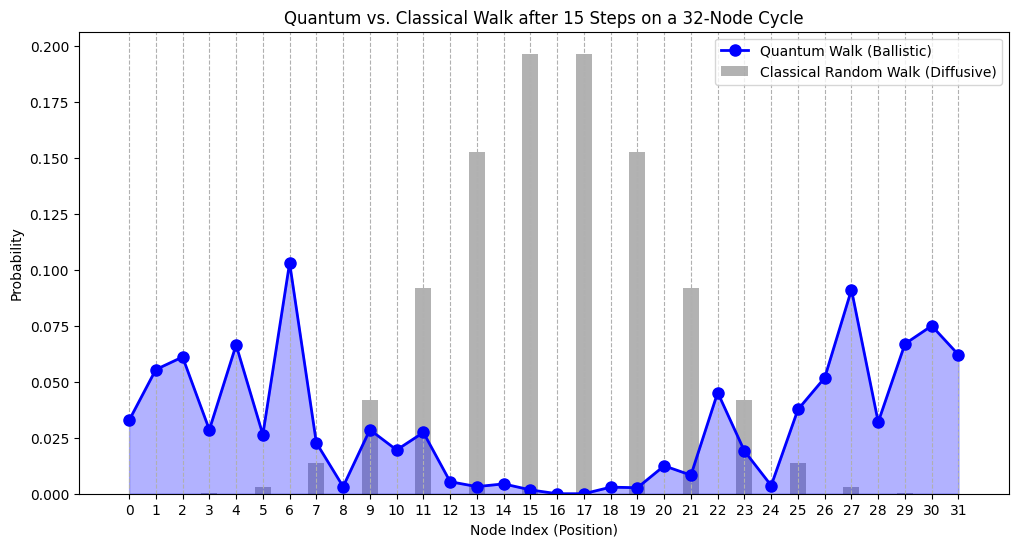

In [ ]:
#Main Execution
if __name__ == "__main__":
    print(f"Architecting Quantum Walk on {N_NODES} nodes for {N_STEPS} steps...")

    # 1. Build and Run Quantum Walk
    qw_circuit = build_quantum_walk_circuit(n_pos_qubits, N_STEPS)
    print("Transpiling and executing via SamplerV2...")
    quantum_probs = run_quantum_simulation(qw_circuit)

    # 2. Run Classical Simulation
    print("Simulating classical equivalent...")
    classical_probs = simulate_classical_walk(N_NODES, N_STEPS)

    # 3. Visualization & Comparison
    x_axis = np.arange(N_NODES)
    plt.figure(figsize=(12, 6))

    # Plot Classical (Diffusive)
    plt.bar(x_axis, classical_probs, color='grey', alpha=0.6, label='Classical Random Walk (Diffusive)', width=0.6)

    # Plot Quantum (Ballistic)
    # Using a line plot with markers for clarity over the bars
    plt.plot(x_axis, quantum_probs, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Quantum Walk (Ballistic)')
    plt.fill_between(x_axis, quantum_probs, color='blue', alpha=0.3)

    plt.title(f"Quantum vs. Classical Walk after {N_STEPS} Steps on a {N_NODES}-Node Cycle")
    plt.xlabel("Node Index (Position)")
    plt.ylabel("Probability")
    plt.xticks(x_axis)
    plt.grid(axis='x', linestyle='--')
    plt.legend()

    print("Execution complete. Displaying results.")
    plt.show()